# Simulating a system of Kern–Frenkel particles

## Overview

### Questions
* How do I implement pairwise energetic interactions in HPMC?

### Objectives
* Run a simulation of particles interacting through the Kern–Frenkel pair potential.
* Log the potential energy during an HPMC simulation.

## Boilerplate code

In [1]:
import os

for _fn in ['initial.gsd', 'log.gsd']:
    fn = os.path.join(os.getcwd(), _fn)
    ![ -e "$fn" ] && rm "$fn"

In [2]:
import gsd.hoomd
import hoomd
import itertools
import math
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use('ggplot')

In the previous section, you learned about patchy particles and the the Kern–Frenkel model.
In this section, we will initialize a system of particles, add the Kern–Frenkel pair potential to the simulation, and run the simulation while logging the energy.

## Constructing the system
Construct the system using the same code you used in [Introducing HOOMD-blue tutorial](../00-Introducing-HOOMD-blue/03-Initializing-the-System-State.ipynb) and then initialize a simulation.

In [3]:
m = 4
N_particles = 2 * m**3
spacing = 1.2
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = position[0:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

# gsd snapshot
snapshot = gsd.hoomd.Frame()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = [0] * N_particles
snapshot.particles.types = ['A']
snapshot.configuration.box = [L, L, L, 0, 0, 0]
with gsd.hoomd.open(name='initial.gsd', mode='xb') as f:
    f.append(snapshot)
    
# build simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=0)
sim.create_state_from_gsd(filename='initial.gsd')

### Add HPMC integrator
Now add an HPMC integrator to the system.
Since the cores of the particles are spherical, we add the `Sphere` integrator.
Since these particles also have an orientation, we must tell HPMC to perform rotation moves on the particles via the `orientable` key of the shape dictionary.

In [4]:
sigma = 1.0  # hard core diameter
kf_lambda = 1.2  # range of patchy interaction
kf_epsilon = 2.0  # strength of patchy interaction in kT
kf_delta_deg = 45  # half-opening angle of patches
mc = hoomd.hpmc.integrate.Sphere()
mc.shape['A'] = dict(diameter=sigma, orientable=True)
sim.operations.integrator = mc

## Add the pair potential

### Write patch code
The `hoomd.hpmc.pair.user` classes uses Python f-strings containing C++ code to evaluate pair potentials.
The code you pass in is the body of the function with the following signature:
```C++
float eval(const vec3<float>& r_ij,
           unsigned int type_i,
           const quat<float>& q_i,
           float d_i,
           float charge_i,
           unsigned int type_j,
           const quat<float>& q_j,
           float d_j,
           float charge_j
)
```
The Kern–Frenkel potential only depends on `r_ij`, `q_i`, and `q_j`, but users have access to the other variables, which can be useful for more complicated systems.
Note the type of `r_ij`, `q_i`, and `q_j`: `vec3` and `quat` are classes that represent 3D vectors and quaternions, respectively, and are defined in [the HOOMD vector math library](https://github.com/glotzerlab/hoomd-blue/blob/trunk-patch/hoomd/VectorMath.h).
The HOOMD vector math library also contains operations you can use on vectors, e.g., you will use `rotate` to rotate the particles into the global frame of reference to evaluate the pair potential.

At the beginning of the body of the function, define some constants:

In [5]:
patch_code = f"""
const float sigma = {sigma:f};  // hard core diameter
const float lambda = {kf_lambda:f};
const float delta = {kf_delta_deg} * M_PI / 180;  // delta in radians
"""

Now set the strength $\varepsilon$ of the patchy interactions.
To do so, first define the temperature $\beta^{-1} = kT$ of the system.
Internally, HOOMD implicitly assumes $\beta = 1$, so to change the temperature of a system in HPMC, you must change the relative strength of the energetic interactions ($\varepsilon$ in this case).

Use `param_array`, which is an array of `float`s that is declared in the patch kernel that you can use to change the value of variables in the patch code.
Later in this section, you will change the temperature of the system by changing the value of `param_array[0]`.

In [6]:
patch_code += f"""
const float kT = param_array[0];
const float beta_epsilon = 1/kT;
"""

Now define the patch director *in the particle frame of reference* using a `vec3` and use `rotate` to rotate particles $i$ and $j$ into the global frame of reference.

In [7]:
patch_code += f"""
const vec3<float> ehat_particle_reference_frame(1, 0, 0);
vec3<float> ehat_i = rotate(q_i, ehat_particle_reference_frame);
vec3<float> ehat_j = rotate(q_j, ehat_particle_reference_frame);
"""

With the particles rotated into the global reference frame, check to see if the patches on each particle are "facing" the other particle.
In other words, evaluate the orientational masking function $f(\Omega_i, \Omega_j)$ defined in [the previous section](01-Kern-Frenkel.ipynb).

In [8]:
patch_code += f"""
vec3<float> r_hat_ij = r_ij / sqrt(dot(r_ij, r_ij));
bool patch_on_i_is_aligned = dot(ehat_i, r_hat_ij) >= cos(delta);
bool patch_on_j_is_aligned = dot(ehat_j, -r_hat_ij) >= cos(delta);
"""

All that's left now is to actually evaluate the pair potential.
In HOOMD, the patch kernel is evaluated after any overlap checks, so we do not need to check for the hard sphere overlap.
Instead, we only need to check if they are within range of the patchy interaction; this condition simplifies to $|\vec{r}_{ij}| < \lambda\sigma$.
For clarity, evaluate the expression as it is written in the previous section, but note that you can avoid the square root calculation by evaluating $|\vec{r}_{ij}|^2 = \vec{r}_{ij} \cdot \vec{r}_{ij} < (\lambda\sigma)^2$.

Note the use of double curly brackets `{{..}}` for the `if..else` code block; Python evaluates expressions inside of curly brackets in f-strings, so we must include a second set of curly brackets so that one set of curly brackets remain after evaluation of the f-string.

In [9]:
patch_code += f"""
float rsq = dot(r_ij, r_ij);
float r_ij_length = sqrt(rsq);
if (patch_on_i_is_aligned && patch_on_j_is_aligned && r_ij_length < lambda*sigma)
    {{
    return -beta_epsilon;
    }}
else
    {{
    return 0.0;
    }}
"""

### Set cutoff distance for the patchy interaction

Before creating the pair potential object to add to the `Simulation`, calculate `r_cut`.
Similar to how HOOMD uses neighborlists in MD to increase performance by only calculating interactions between "nearby" particles, the `hoomd.hpmc.pair.user` classes take an `r_cut` parameter, which is the center to center distance cutoff beyond which all pair interactions are 0.
Here, that distance is the hard core diameter $\sigma$ plus the radial extent of the patchy interaction $\sigma(\lambda-1)$.

In [10]:
r_cut = sigma + sigma * (kf_lambda - 1)

### Set variable parameters for patch kernel

Create the array to used to control the temperature and initialize to a value of $kT = 3$ to radomize the system on the first call to `Simulation.run()`.

In [11]:
initial_kT = 3.0
patch_param_array = [initial_kT]

### Adding the patchy potential to the simulation

Now create a `hoomd.hpmc.pair.user.CPPPotential` object that will evaluate the Kern–Frenkel potential in the simulation.

In [12]:
patch_potential = hoomd.hpmc.pair.user.CPPPotential(r_cut,
                                                    patch_code,
                                                    patch_param_array)

Finally, attach `patch_potential` to the HPMC integrator so that the integrator evaluates the pair potential.

In [13]:
mc.pair_potential = patch_potential

You can query the energy associated with the patch potential via the `energy` property of the patch potential object (after running for 0 or more steps).
The particles are not interacting in the initial configuration, and hence the initial value of the energy is zero.

In [14]:
sim.run(0)
patch_potential.energy

0.0

### Log the patch energy

Create a logger and add the patchy potential to it, and then create a GSD writer to write the log values to file during the simulation.
Also add the temperature to the logger so that later you can compare energies from parts of the simulation at different temperatures.

In [15]:
logger = hoomd.logging.Logger()
logger.add(patch_potential, quantities=['energy',])
logger[('kT',)] = (lambda: patch_potential.param_array[0], 'scalar')
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(10),
                             mode='xb',
                             filter=hoomd.filter.Null(),
                             logger=logger)
sim.operations.writers.append(gsd_writer)

## Run the simulation

### Randomize the system
Run for a bit at the high initial temperature to randomize the system.

In [16]:
sim.run(500)

### Change the temperature
Now run for a bit at a lower temperature so that the patchy interactions cause the particles to cluster.
Recall, the `param_array` property of the patch potential is the effective temperature of the system.

In [17]:
patch_potential.param_array[0] = 0.1
sim.run(2000)

Now, increase the temperature again so that the clusters break apart.

In [18]:
patch_potential.param_array[0] = 3
sim.run(2000)

## Analyzing the results

You have initialized and randomized a system of patchy particles.
Now plot the energy of the system to analyze the results.

Use the `gsd` package to read just the `log` values from the GSD file.

In [19]:
data = gsd.hoomd.read_log('log.gsd')
step = data['configuration/step']

Recall, the the value of `patch_potential.energy` is really the energy divided by the thermal energy scale $kT$, so multiply the energy by $kT$ to get the actual energy.

In [20]:
beta_potential_energy = data['log/hpmc/pair/user/CPPPotential/energy']
kT = data['log/kT']
potential_energy = beta_potential_energy * kT

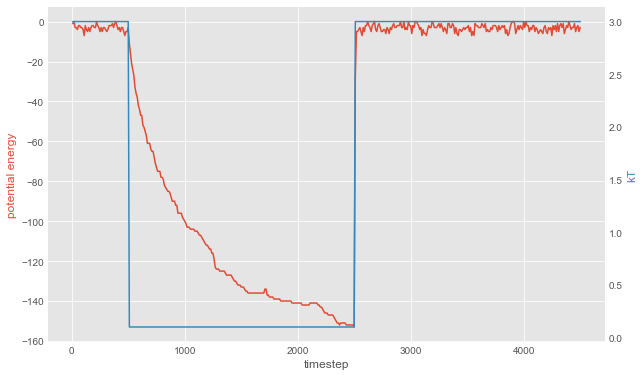

In [21]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ll, = ax.plot(step, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy', c=ll.get_c())

ax2 = ax.twinx()
ax2.grid(False)
ax2._get_lines.get_next_color()
ll, = ax2.plot(step, kT)
ylabel = ax2.set_ylabel('kT', c=ll.get_c())

fig

Notice the decrease in energy when the temperature was at the lower setting, indicative of particle clustering. 

## Summary
In this tutorial, you learned about patchy particles and the Kern–Frenkel model of patchy particles, and you implemented the Kern–Frenkel model in HPMC.
You observed the change in potential energy upon changing the temperature in a patchy particle simulation.

For more information on simulating patchy particles, or more generally HPMC simulations with energetic interactions, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/en/latest/module-hpmc-pair.html) on pair potentials in HPMC.